In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from activ.analytics import heatmap
from scipy.io import loadmat
from PyUoI.UoINMF import UoINMF
from hdbscan import HDBSCAN
from sklearn.exceptions import ConvergenceWarning
from datetime import datetime
import warnings
import numpy as np
from sklearn.decomposition import NMF
from matplotlib.backends.backend_pdf import PdfPages
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import minmax_scale
import h5py
import os.path

np.random.seed(10)

In [2]:
class UMAPHDBSCAN(object):
    def __init__(self, umap, hdbscan):
        self.hdbscan = hdbscan
        self.umap = umap
        
    def fit_predict(self, X, y=None):
        return self.hdbscan.fit_predict(self.umap.fit_transform(X))

In [3]:
def intersect(samples, **kwargs):
    selected = np.all(samples > 0.0, axis=0)
    ret = np.zeros(samples.shape[1])
    ret[selected] = np.mean(samples, axis=0)[selected]
    return ret

In [4]:
input_path = os.path.join("..", "Swimmer.h5")
f = h5py.File(input_path, 'r+')
Swimmers= f['Y'][:]
f.close()
Swimmers = Swimmers.T.reshape(256, 1024)
Swimmers = minmax_scale(Swimmers, axis=1)

/Users/ajtritt/anaconda/envs/activ/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [5]:
pdf = PdfPages('../Swimmer_UoINMF.pdf')
def savefig(fig=None):
    try:
        pdf.savefig(figure=fig)
    except Exception as e:
        print("cant save to pdf")

Original Swimmer samples
=========================

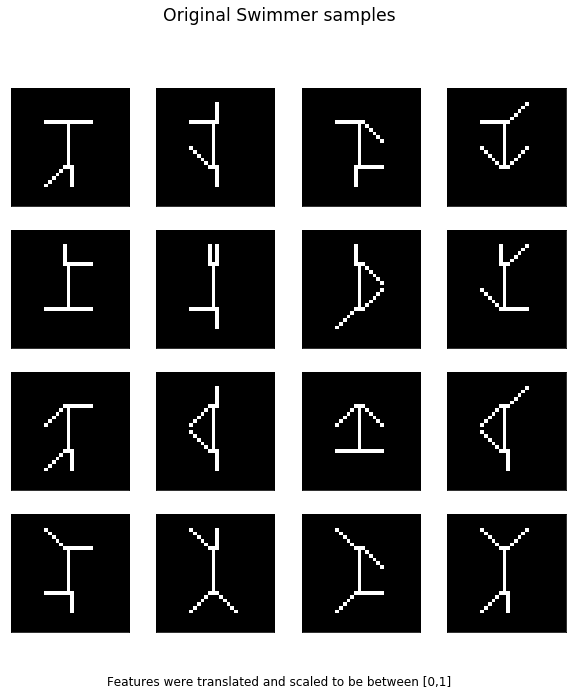

In [6]:
fig, ax = plt.subplots(4, 4, figsize=(10,10), subplot_kw={'xticks': [], 'yticks': []})
indices = np.random.randint(16, size=16) + np.arange(0, 256, 16)
ax = ax.flatten()
for i in range(len(indices)):
    heatmap(Swimmers[indices[i]].reshape(32,32).T, ticks=False, ax=ax[i], cbar=False, cmap='gray')
fig.suptitle("Original Swimmer samples", fontsize='xx-large', verticalalignment='center')
fig.text(.5, .05, "Features were translated and scaled to be between [0,1]", ha='center', fontsize=12)
savefig(fig)

In [7]:
s = Swimmers.shape
reps = 10
corrupted = np.zeros((s[0]*reps, s[1]))

print("Corrupting %d replicates of Swimmer dataset with absolute Gaussian noise" % reps)

for r in range(reps):
    corrupted[r*s[0]:(r+1)*s[0]] = Swimmers + np.abs(np.random.normal(scale=0.25, size=Swimmers.shape))

Corrupting 10 replicates of Swimmer dataset with absolute Gaussian noise


Swimmer samples corrupted with Absolute Gaussian noise
======================================================
Noise was randomly sampled from |N(0,0.25)|

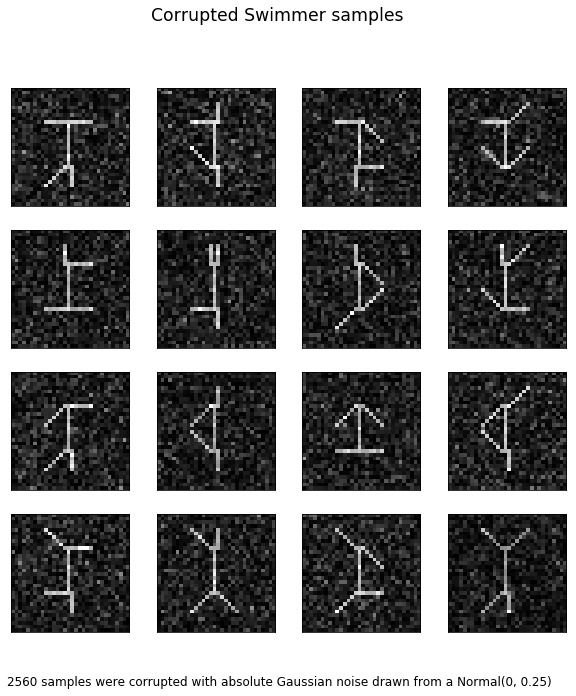

In [8]:
fig, ax = plt.subplots(4, 4, figsize=(10,10), subplot_kw={'xticks': [], 'yticks': []})
ax = ax.flatten()
for i in range(len(indices)):
    heatmap(corrupted[indices[i]].reshape(32,32).T, ticks=False, ax=ax[i], cbar=False, cmap="gray")
fig.suptitle("Corrupted Swimmer samples ", fontsize='xx-large', verticalalignment='center')
fig.text(.5, .05, "%d samples were corrupted with absolute Gaussian noise drawn from a Normal(0, 0.25)" % corrupted.shape[0], ha='center', fontsize=12)
savefig(fig)

In [9]:
nboot = 20
min_pts = nboot/2
ranks = [16]

shape = corrupted.shape

uoinmf = UoINMF(n_bootstraps=nboot, ranks=ranks,
                dbscan=DBSCAN(min_samples=min_pts),
                nmf=NMF(beta_loss='kullback-leibler', solver='mu', max_iter=400, init='random'))

print(repr(uoinmf))

uoinmf.cons_meth = np.median   # intersect and mean give too much noise

transformed = None
before = datetime.now()
with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter('ignore', ConvergenceWarning)
    transformed = uoinmf.fit_transform(corrupted)
    print("Caught %d ConvergenceWarnings" % len(w))
after = datetime.now()
recovered = transformed @ uoinmf.components_

#MM = UMAP(n_components=2, min_dist=0.0)
MM = TSNE(n_components=2)
embedding = MM.fit_transform(uoinmf.bases_samples_)
bases = uoinmf.components_

print("Took %s." % (after - before), "Found %s bases" % bases.shape[0])

UoINMF(cons_meth=<function median at 0x10e94d730>,
    dbscan=DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=10.0, n_jobs=1, p=None),
    n_bootstraps=20,
    nmf=NMF(alpha=0.0, beta_loss='kullback-leibler', init='random', l1_ratio=0.0,
  max_iter=400, n_components=None, random_state=None, shuffle=False,
  solver='mu', tol=0.0001, verbose=0),
    nnreg=<function UoINMF.__initialize.<locals>.<lambda> at 0x1167bcbf8>,
    random_state=None, ranks=(16,))
Caught 0 ConvergenceWarnings
Took 0:04:16.183070. Found 16 bases


NMF Swimmer bases
=================

(16, 1024)


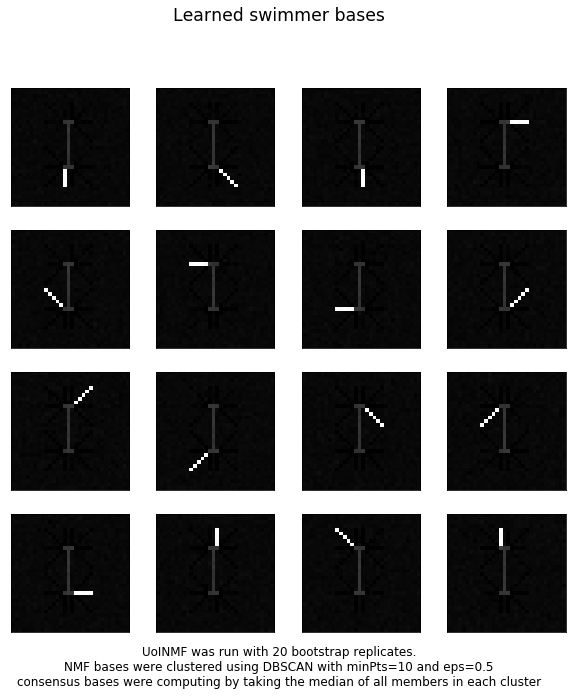

In [10]:

print(bases.shape)
order = np.argsort(np.sum(bases, axis=1))

nrow = 5 if bases.shape[0] > 16 else 4

fig, ax = plt.subplots(nrow,4, figsize=(10,10), subplot_kw={'xticks': [], 'yticks': []})
ax = ax.flatten()
for i in range(bases.shape[0]):
    heatmap(bases[order[i]].reshape(32,32).T, ticks=False, ax=ax[i], cbar=False, cmap='gray')
fig.suptitle("Learned swimmer bases", fontsize='xx-large', verticalalignment='center')

caption = ("UoINMF was run with 20 bootstrap replicates.\n"
           "NMF bases were clustered using %s with minPts=%d and eps=0.5\n"
           "consensus bases were computing by taking the median of all members in each cluster")

caption = caption % (uoinmf.dbscan.__class__.__name__, uoinmf.dbscan.min_samples)

fig.text(.5, .05, caption, ha='center', fontsize=12)
savefig(fig)

Recovered Swimmers
==================

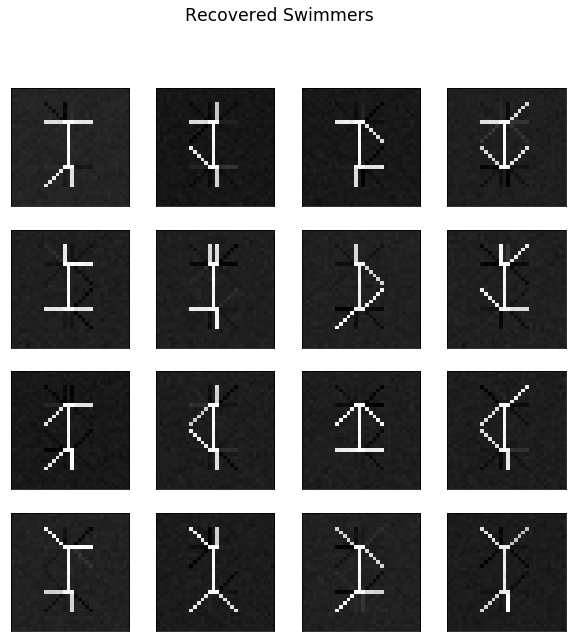

In [11]:
fig, ax = plt.subplots(4, 4, figsize=(10,10), subplot_kw={'xticks': [], 'yticks': []})
ax = ax.flatten()
for i in range(len(indices)):
    heatmap(recovered[indices[i]].reshape(32,32).T, ticks=False, ax=ax[i], cbar=False, cmap='gray')
    
fig.suptitle("Recovered Swimmers", fontsize='xx-large', verticalalignment='center')
savefig(fig)

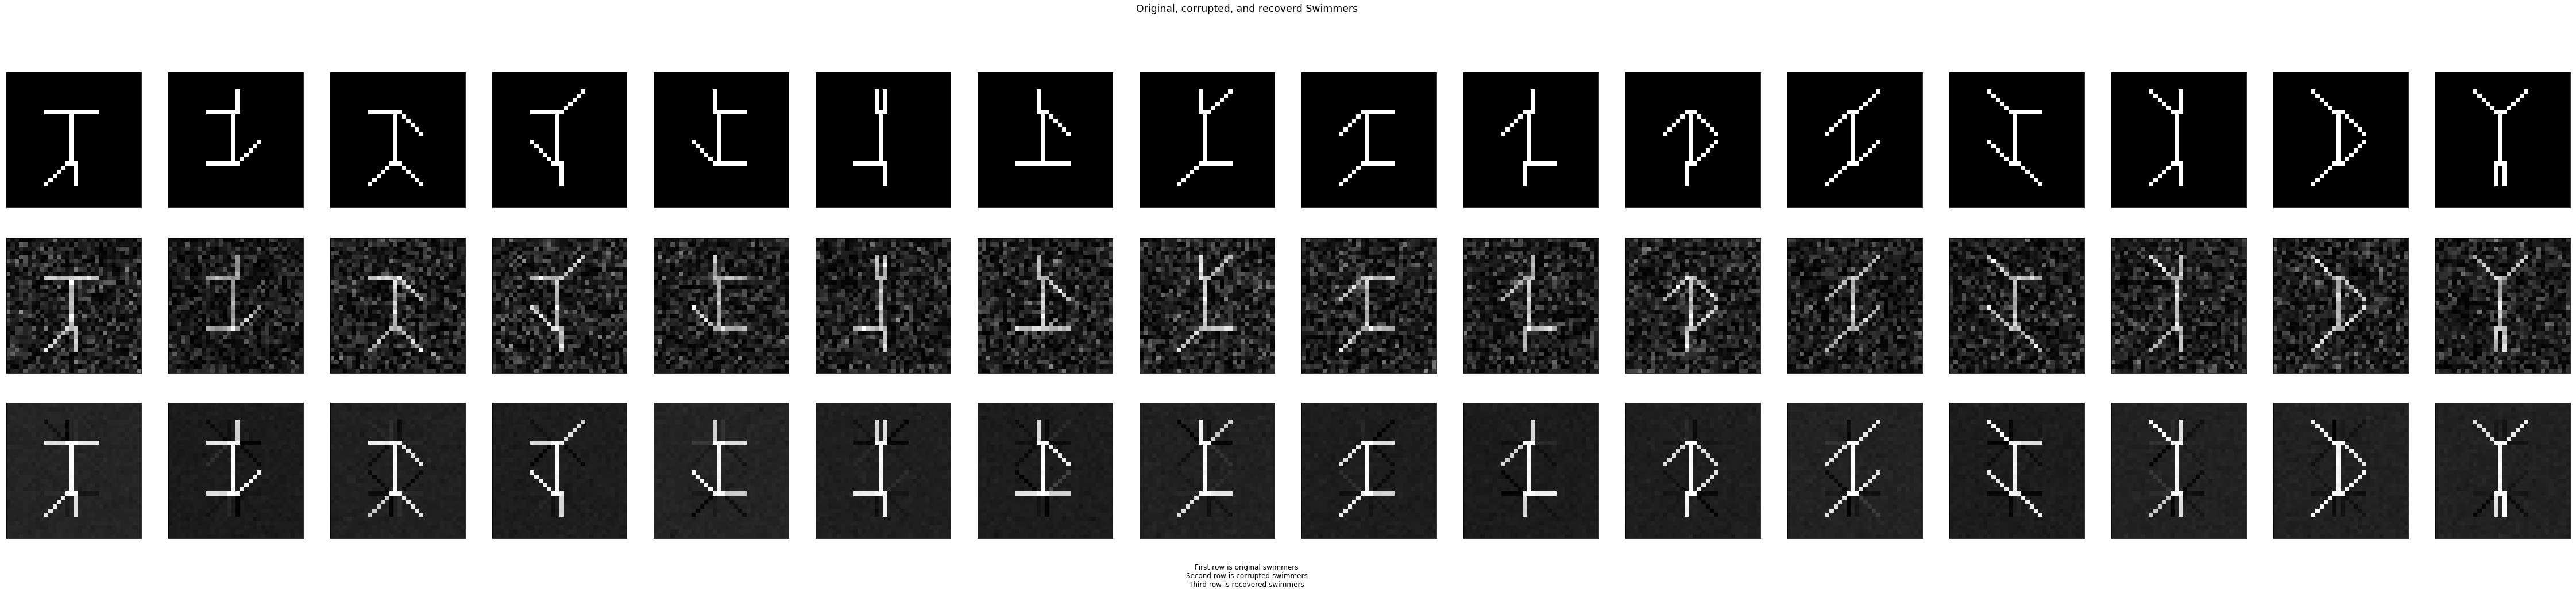

In [12]:
fig, ax = plt.subplots(3, 16, figsize=(80, 15), subplot_kw={'xticks': [], 'yticks': []})
indices = np.random.randint(16, size=16) + np.arange(0, 256, 16)
ax = ax.flatten()
for i in range(len(indices)):
    heatmap(Swimmers[indices[i]].reshape(32,32).T, ticks=False, ax=ax[i], cbar=False, cmap='gray')
for i in range(len(indices)):
    heatmap(corrupted[indices[i]].reshape(32,32).T, ticks=False, ax=ax[16+i], cbar=False, cmap="gray")
for i in range(len(indices)):
    heatmap(recovered[indices[i]].reshape(32,32).T, ticks=False, ax=ax[32+i], cbar=False, cmap='gray')
    
fig.suptitle("Original, corrupted, and recoverd Swimmers", fontsize='xx-large', verticalalignment='center')

caption = ("First row is original swimmers\n"
           "Second row is corrupted swimmers\n"
           "Third row is recovered swimmers")

fig.text(.5, .05, caption, ha='center', fontsize=12)
savefig(fig)

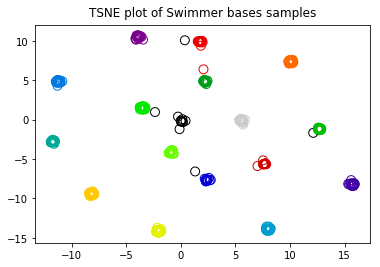

In [13]:
sc = plt.scatter(embedding[:,0], embedding[:,1], c=uoinmf.bases_samples_labels_, s=80, cmap="nipy_spectral")
sc.set_facecolor('none')

plt.title("%s plot of Swimmer bases samples" % MM.__class__.__name__, fontsize='large', verticalalignment='bottom')
savefig()

In [14]:
pdf.close()

In [15]:
def add_dset(g, name, dat, desc):
    dset = g.require_dataset(name, shape=dat.shape, dtype=dat.dtype)
    dset[...] = dat
    dset.attrs['description'] = desc
    return dset

output_path = os.path.join("..", "Swimmer_uoinmf_results.h5")
f = h5py.File(output_path, 'w')
Swimmers = Swimmers.T.reshape((256, 32*32))
Swimmers = minmax_scale(Swimmers, axis=1)
dset = add_dset(f, 'Swimmers', Swimmers, "reshaped and scaled to [0,1]")
dset = add_dset(f, 'Swimmers_corrupted', corrupted, "Swimmers with absolute random noise i.e. |N(0, 0.25)|")
dset = add_dset(f, 'Swimmers_bases_samples', uoinmf.bases_samples_, 'generated with UoINMF: %s' % repr(uoinmf))
dset = add_dset(f, 'Swimmers_bases', uoinmf.components_, 'generated with UoINMF: %s' % repr(uoinmf))
dset = add_dset(f, 'Swimmers_bases_samples_embeddings', embedding, 'generated with %s: %s' % (MM.__class__.__name__, repr(MM)))
f.close()